In [1]:
import pandas as pd
import numpy as np

# =========================
# 1️⃣ LOAD DATA
# =========================
file_path = r"C:\Users\trish\Downloads\Smart_Rewards_LiveStyle_With_Violations.xlsx"

df = pd.read_excel(file_path, sheet_name="Transactions")

# =========================
# 2️⃣ STANDARDIZE COLUMNS
# =========================
df.columns = df.columns.str.strip().str.lower()

# =========================
# 3️⃣ FIX DATE (MOST IMPORTANT)
# =========================
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Drop rows where date or amount is missing
df = df.dropna(subset=["date", "amount", "card_id"])

# =========================
# 4️⃣ CREATE TIME FEATURES
# =========================
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["month_year"] = df["date"].dt.to_period("M").astype(str)

# =========================
# 5️⃣ FIX AMOUNT COLUMN
# =========================
df["amount"] = pd.to_numeric(df["amount"], errors="coerce").fillna(0)

# =========================
# 6️⃣ FIX BOOLEAN COLUMNS SAFELY
# =========================
def to_bool(series):
    return (
        series.astype("string")
              .str.strip()
              .str.lower()
              .map({"true": True, "false": False, "1": True, "0": False})
              .fillna(False)
              .astype(bool)
    )

bool_cols = [
    "merchant_limit_violated",
    "card_credit_limit_exceeded"
]

for col in bool_cols:
    if col not in df.columns:
        df[col] = False
    df[col] = to_bool(df[col])

# =========================
# 7️⃣ QUICK SANITY CHECKS
# =========================
print("✅ Total rows:", len(df))
print("✅ Date range:", df["date"].min(), "to", df["date"].max())
print("✅ Unique users:", df["ssn"].nunique())
print("✅ Unique cards:", df["card_id"].nunique())
print("✅ Total amount:", round(df["amount"].sum(), 2))

# =========================
# 8️⃣ SHOW SAMPLE DATA (NO COLUMN TRUNCATION)
# =========================
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

df.head(10)

✅ Total rows: 2000
✅ Date range: 2024-01-25 00:00:00 to 2026-01-23 00:00:00
✅ Unique users: 250
✅ Unique cards: 15
✅ Total amount: 267390.49


,transaction_id,date,month,ssn,person_name,gender,age,person_credit_limit,card_id,card_name,card_credit_limit,category,merchant,amount,cashback_rate_%,cashback_amount,transaction_type,channel,status,merchant_spend_limit,merchant_limit_violated,monthly_card_spend,card_credit_limit_exceeded,monthly_expenditure,yearly_expenditure,year,month_year
0,TXN000572,2024-03-09,3,101-17-1037,Kavya Mehta,Male,38,19058,CC001,Chase Sapphire Reserve,4809,Gas,Sunoco,234.24,4.0,9.37,Fee,Contactless,Completed,NaN,False,234.24,False,234.24,678.77,2024,2024-03
1,TXN001902,2024-05-11,5,101-17-1037,Kavya Mehta,Male,38,19058,CC001,Chase Sapphire Reserve,4809,Travel,United Airlines,144.45,1.5,2.17,Fee,In-Store,Completed,NaN,False,236.44,False,236.44,678.77,2024,2024-05
2,TXN001296,2024-05-22,5,101-17-1037,Kavya Mehta,Male,38,19058,CC001,Chase Sapphire Reserve,4809,Groceries,Target,91.99,2.0,1.84,Purchase,Online,Completed,NaN,False,236.44,False,236.44,678.77,2024,2024-05
3,TXN000239,2024-08-03,8,101-17-1037,Kavya Mehta,Male,38,19058,CC015,Barclays Arrival Plus,8098,Travel,Airbnb,208.09,4.0,8.32,Fee,Mobile App,Completed,NaN,False,208.09,False,208.09,678.77,2024,2024-08
4,TXN001085,2025-01-21,1,101-17-1037,Kavya Mehta,Male,38,19058,CC015,Barclays Arrival Plus,8098,Streaming,Hulu,207.89,1.0,2.08,Subscription,In-Store,Completed,NaN,False,207.89,False,207.89,269.23,2025,2025-01
5,TXN001160,2025-08-31,8,101-17-1037,Kavya Mehta,Male,38,19058,CC015,Barclays Arrival Plus,8098,Gas,Chevron,61.34,4.0,2.45,Refund,Online,Completed,NaN,False,61.34,False,61.34,269.23,2025,2025-08
6,TXN000029,2026-01-12,1,101-17-1037,Kavya Mehta,Male,38,19058,CC015,Barclays Arrival Plus,8098,Shopping,Sephora,198.24,1.5,2.97,Refund,Mobile App,Completed,100.0,False,198.24,False,198.24,198.24,2026,2026-01
7,TXN000992,2024-05-24,5,102-24-1074,Daniel Garcia,Male,45,67842,CC007,Chase Freedom Unlimited,8515,Travel,Hilton,9.02,5.0,0.45,Subscription,In-Store,Pending,NaN,False,9.02,False,9.02,351.13,2024,2024-05
8,TXN001087,2024-09-13,9,102-24-1074,Daniel Garcia,Male,45,67842,CC007,Chase Freedom Unlimited,8515,Dining,Olive Garden,34.28,1.0,0.34,Refund,Online,Completed,NaN,False,199.80,False,199.80,351.13,2024,2024-09
9,TXN000195,2024-09-14,9,102-24-1074,Daniel Garcia,Male,45,67842,CC007,Chase Freedom Unlimited,8515,Travel,Marriott,165.52,2.0,3.31,Subscription,Online,Completed,NaN,False,199.80,False,199.80,351.13,2024,2024-09


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score,
                             confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve)

# Load
df = pd.read_excel(r"C:\Users\trish\Downloads\Smart_Rewards_LiveStyle_With_Violations.xlsx",
                   sheet_name="Transactions")

df.columns = df.columns.str.strip().str.lower()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date", "amount", "card_id"])
df["amount"] = pd.to_numeric(df["amount"], errors="coerce").fillna(0)

df["month_year"] = df["date"].dt.to_period("M").astype(str)
df["year"] = df["date"].dt.year
df["dow"] = df["date"].dt.dayofweek
df["is_weekend"] = (df["dow"] >= 5).astype(int)

# normalize booleans safely
def to_bool(x):
    s = x.astype("string").str.strip().str.lower()
    return s.map({"true": True, "false": False, "1": True, "0": False}).fillna(False).astype(bool)

for c in ["merchant_limit_violated","card_credit_limit_exceeded"]:
    if c not in df.columns: df[c] = False
    df[c] = to_bool(df[c])

# numeric limits if present
for c in ["merchant_spend_limit","card_credit_limit"]:
    if c not in df.columns: df[c] = np.nan
    df[c] = pd.to_numeric(df[c], errors="coerce")

# ratios (helpful features)
df["amt_vs_mlimit"] = np.where(df["merchant_spend_limit"].fillna(0) > 0,
                               df["amount"]/df["merchant_spend_limit"], 0)
df["amt_vs_climit"] = np.where(df["card_credit_limit"].fillna(0) > 0,
                               df["amount"]/df["card_credit_limit"], 0)

 1) Logistic Regression — Risk Event Detection (Explainable baseline)

What problem it solves

“Should I flag this transaction as risky or not?” (a simple yes/no).
Columns used: card_id, category, merchant, amount, dow, is_weekend, amt_vs_mlimit, amt_vs_climit and the label we create.
What you get: a clear baseline with precision/recall/F1; great for proving that XGBoost/forests actually improve things

In [3]:
from sklearn.linear_model import LogisticRegression

# Define label: risky if merchant violation OR credit limit exceeded
df["label_risk"] = (df["merchant_limit_violated"] | df["card_credit_limit_exceeded"]).astype(int)

cat_cols = ["card_id","category","merchant"]
num_cols = ["amount","dow","is_weekend","amt_vs_mlimit","amt_vs_climit"]
X = df[cat_cols + num_cols]
y = df["label_risk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

prep = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols)
])

model = LogisticRegression(max_iter=200)
clf = Pipeline([("prep", prep), ("model", model)])
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

p = precision_score(y_test, y_pred, zero_division=0)
r = recall_score(y_test, y_pred, zero_division=0)
f = f1_score(y_test, y_pred, zero_division=0)

print("LogReg -> Precision:", round(p,3), "Recall:", round(r,3), "F1:", round(f,3))

LogReg -> Precision: 0.75 Recall: 0.214 F1: 0.333


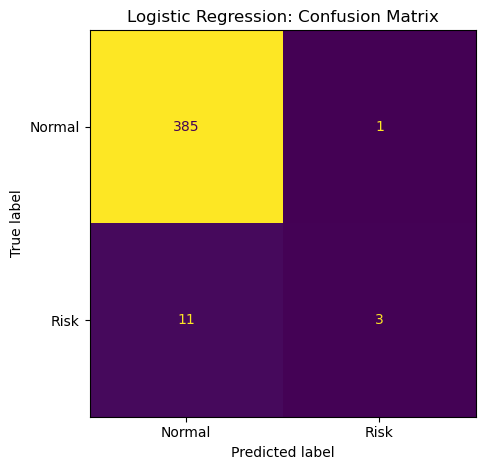

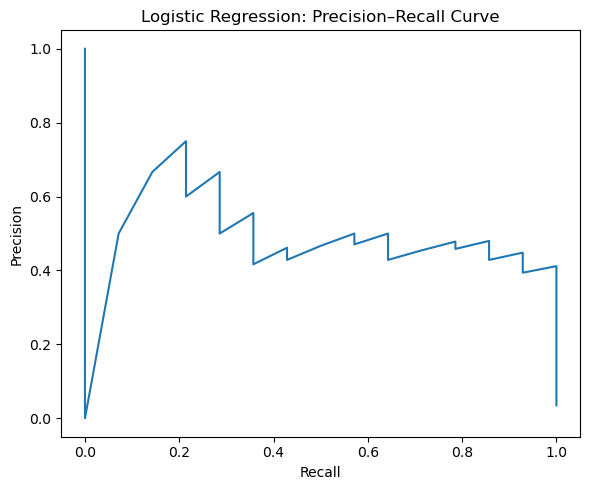

In [5]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Normal","Risk"]).plot(colorbar=False)
plt.title("Logistic Regression: Confusion Matrix")
plt.tight_layout()
plt.show()

prec, rec, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(rec, prec)
plt.title("Logistic Regression: Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()

2) Random Forest — Predict Merchant Rule Violations

What problem it solves

“Will this purchase violate the merchant spending rule (e.g., Starbucks > $100)?”
Columns used: merchant, category, amount, merchant_spend_limit, amt_vs_mlimit, card_id
Label: merchant_limit_violated
What you get: a strong, robust model that captures non-linear patterns (“this merchant + this amount tends to violate”).

In [4]:
from sklearn.ensemble import RandomForestClassifier

df_m = df[df["merchant_spend_limit"].notna()].copy()
X = df_m[["merchant","category","card_id","amount","merchant_spend_limit","amt_vs_mlimit"]]
y = df_m["merchant_limit_violated"].astype(int)

cat_cols = ["merchant","category","card_id"]
num_cols = ["amount","merchant_spend_limit","amt_vs_mlimit"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

prep = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])

rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced")
clf = Pipeline([("prep", prep), ("model", rf)])
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("RF -> Accuracy:", round(accuracy_score(y_test, y_pred),3))
print("RF -> Precision:", round(precision_score(y_test, y_pred, zero_division=0),3),
      "Recall:", round(recall_score(y_test, y_pred, zero_division=0),3),
      "F1:", round(f1_score(y_test, y_pred, zero_division=0),3))

RF -> Accuracy: 0.615
RF -> Precision: 0.25 Recall: 0.077 F1: 0.118


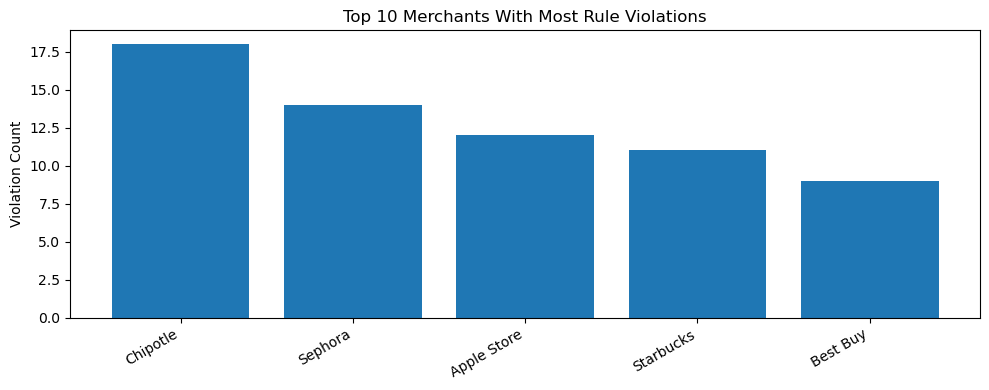

In [8]:
top_merch = (df_m[df_m["merchant_limit_violated"]]
             .groupby("merchant")["amount"].count()
             .sort_values(ascending=False).head(10))

plt.figure(figsize=(10,4))
plt.bar(top_merch.index, top_merch.values)
plt.title("Top 10 Merchants With Most Rule Violations")
plt.ylabel("Violation Count")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

3) XGBoost (or GradientBoosting fallback) — Credit Limit Exceed Prediction

What problem it solves

“Will the card exceed its credit limit this month?” (predict card_credit_limit_exceeded).
Columns used: card_id, category, merchant, amount, month_year, card_credit_limit, amt_vs_climit plus a monthly card spend feature.
What you get: higher accuracy vs baseline, and a realistic “risk early warning.

In [6]:
!pip install xgboost


   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB 320.0 kB/s eta 0:03:45
   ---------------------------------------- 0.1/72.0 MB 1.2 MB/s eta 0:01:02
   ---------------------------------------- 0.6/72.0 MB 3.8 MB/s eta 0:00:19
    --------------------------------------- 1.7/72.0 MB 9.6 MB/s eta 0:00:08
   - -------------------------------------- 3.0/72.0 MB 12.6 MB/s eta 0:00:06
   -- ------------------------------------- 3.6/72.0 MB 12.8 MB/s eta 0:00:06
   -- ------------------------------------- 4.8/72.0 MB 14.5 MB/s eta 0:00:05
   --- ------------------------------------ 6.0/72.0 MB 16.6 MB/s eta 0:00:04
   --- ------------------------------------ 7.1/72.0 MB 17.4 MB/s eta 0:00:04
   ---- ----------------------------------- 7.6/72.0 MB 17.9 MB/s eta 0:00:04
   ---- ----------------------------------- 8.8/72.0 MB 18.7 MB/s eta 0:00:04
   ----- ---------------------------------- 10.2/72.0 MB 19.8 MB/s eta 0:0

In [7]:
# =========================
# 0️⃣ IMPORTS
# =========================
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score
from xgboost import XGBClassifier

# =========================
# 1️⃣ ENSURE REQUIRED COLUMNS
# =========================
required_cols = [
    "ssn", "card_id", "category", "merchant",
    "amount", "date", "card_credit_limit",
    "card_credit_limit_exceeded"
]

for col in required_cols:
    if col not in df.columns:
        df[col] = np.nan

# =========================
# 2️⃣ FIX DATA TYPES
# =========================
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["amount"] = pd.to_numeric(df["amount"], errors="coerce").fillna(0)
df["card_credit_limit"] = pd.to_numeric(df["card_credit_limit"], errors="coerce")

df["card_credit_limit_exceeded"] = (
    df["card_credit_limit_exceeded"]
    .astype("string")
    .str.lower()
    .map({"true": 1, "false": 0, "1": 1, "0": 0})
    .fillna(0)
    .astype(int)
)

# =========================
# 3️⃣ TIME FEATURE
# =========================
df["month_year"] = df["date"].dt.to_period("M").astype(str)

# =========================
# 4️⃣ MONTHLY CARD SPEND (ALWAYS REBUILT)
# =========================
monthly_card_spend = (
    df.groupby(["ssn", "card_id", "month_year"], as_index=False)["amount"]
      .sum()
      .rename(columns={"amount": "monthly_card_spend"})
)

# =========================
# 5️⃣ MERGE BACK (SAFE FOR RE-RUNS)
# =========================
df_model = df.merge(
    monthly_card_spend,
    on=["ssn", "card_id", "month_year"],
    how="left"
)

# Resolve merge suffixes (_x / _y)
if "monthly_card_spend" not in df_model.columns:
    if "monthly_card_spend_y" in df_model.columns:
        df_model["monthly_card_spend"] = df_model["monthly_card_spend_y"]
    elif "monthly_card_spend_x" in df_model.columns:
        df_model["monthly_card_spend"] = df_model["monthly_card_spend_x"]
    else:
        raise ValueError("monthly_card_spend could not be created")

df_model = df_model.drop(
    columns=[c for c in df_model.columns if c.endswith("_x") or c.endswith("_y")],
    errors="ignore"
)

# =========================
# 6️⃣ RATIO FEATURE
# =========================
df_model["amt_vs_climit"] = np.where(
    df_model["card_credit_limit"].notna() & (df_model["card_credit_limit"] > 0),
    df_model["amount"] / df_model["card_credit_limit"],
    0
)

# =========================
# 7️⃣ FEATURE MATRIX + TARGET
# =========================
X = df_model[
    [
        "card_id",
        "category",
        "merchant",
        "amount",
        "monthly_card_spend",
        "card_credit_limit",
        "amt_vs_climit"
    ]
]

y = df_model["card_credit_limit_exceeded"]

# =========================
# 8️⃣ TIME-SAFE TRAIN / TEST SPLIT
# (guarantees both classes in training)
# =========================
first_positive_idx = y[y == 1].index.min()
split_idx = int(len(df_model) * 0.8)

if pd.notna(first_positive_idx) and first_positive_idx > split_idx:
    split_idx = first_positive_idx + 1

X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]

X_test = X.iloc[split_idx:]
y_test = y.iloc[split_idx:]

print("Training label distribution:")
print(y_train.value_counts())
print("\nTest label distribution:")
print(y_test.value_counts())

# =========================
# 9️⃣ PREPROCESSING
# =========================
cat_cols = ["card_id", "category", "merchant"]
num_cols = ["amount", "monthly_card_spend", "card_credit_limit", "amt_vs_climit"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

# =========================
# 🔟 XGBOOST MODEL (SAFE INIT)
# =========================
base_score = float(y_train.mean())
base_score = min(max(base_score, 0.01), 0.99)

model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.08,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="binary:logistic",
    eval_metric="logloss",
    base_score=base_score,
    use_label_encoder=False,
    random_state=42
)

print(f"\n✅ Using XGBoost (base_score={round(base_score,3)})")

# =========================
# 1️⃣1️⃣ PIPELINE
# =========================
pipeline = Pipeline(
    steps=[
        ("prep", preprocess),
        ("model", model)
    ]
)

# =========================
# 1️⃣2️⃣ TRAIN MODEL
# =========================
pipeline.fit(X_train, y_train)

# =========================
# 1️⃣3️⃣ EVALUATE
# =========================
y_pred = pipeline.predict(X_test)

precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("\n📊 Credit Limit Exceed Prediction Results")
print("Precision:", round(precision, 3))
print("Recall:   ", round(recall, 3))
print("F1 Score: ", round(f1, 3))


Training label distribution:
card_credit_limit_exceeded
0    1600
Name: count, dtype: int64

Test label distribution:
card_credit_limit_exceeded
0    400
Name: count, dtype: int64

✅ Using XGBoost (base_score=0.01)

📊 Credit Limit Exceed Prediction Results
Precision: 0.0
Recall:    0.0
F1 Score:  0.0


C:\Users\trish\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [07:36:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\trish\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


IndexError: index 1 is out of bounds for axis 1 with size 1

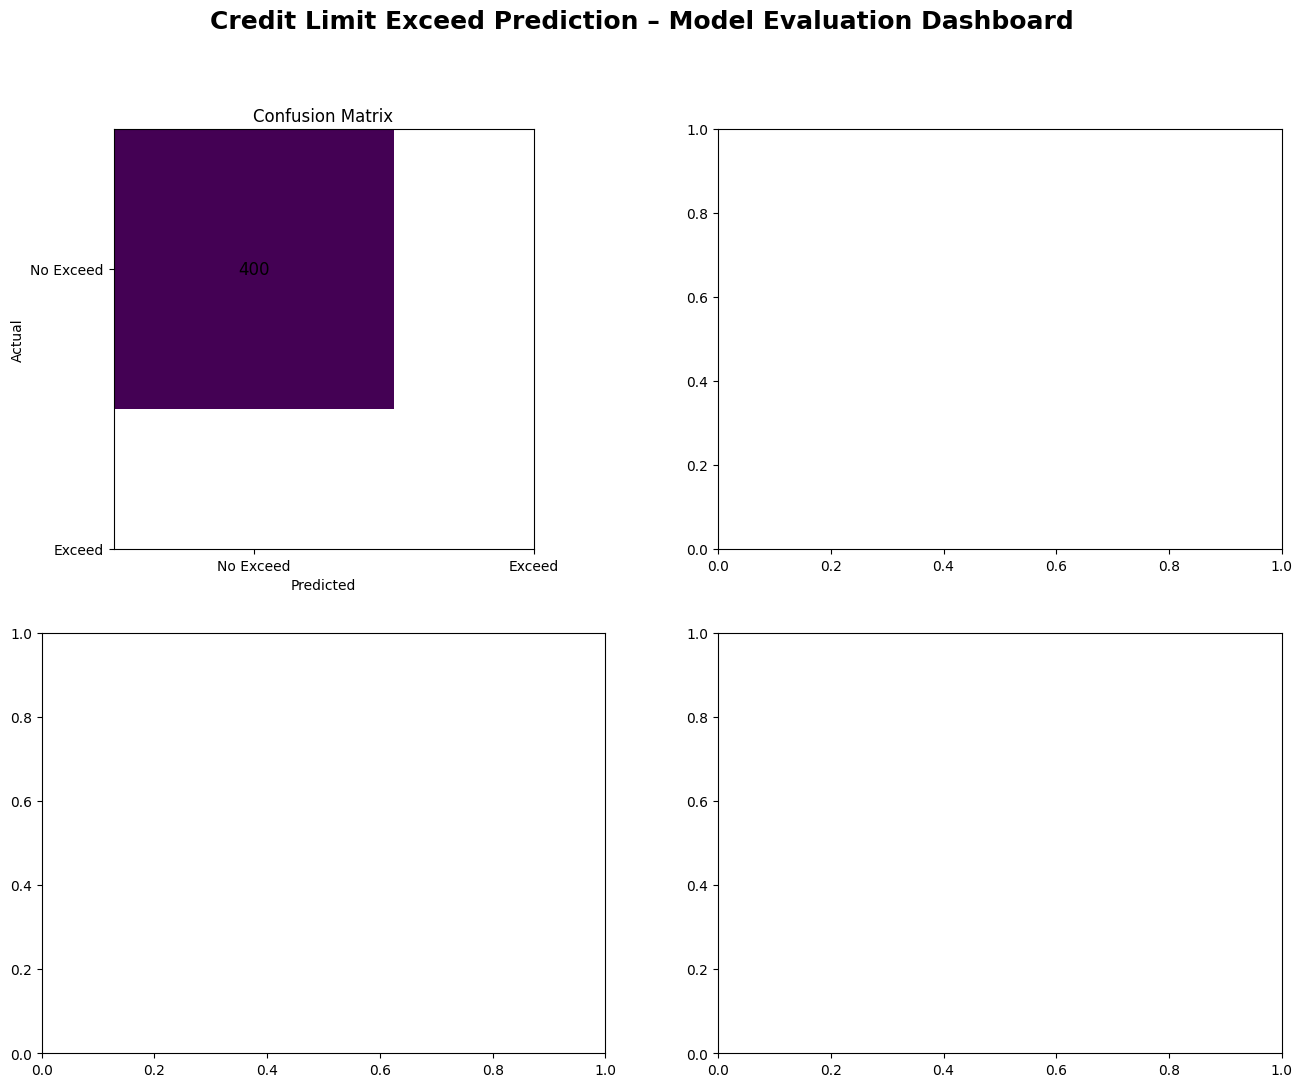

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc
)

# -----------------------------
# Predictions & Probabilities
# -----------------------------
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# -----------------------------
# Create 2x2 Layout
# -----------------------------
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(
    "Credit Limit Exceed Prediction – Model Evaluation Dashboard",
    fontsize=18,
    fontweight="bold"
)

# =============================
# 1️⃣ Confusion Matrix
# =============================
cm = confusion_matrix(y_test, y_pred)
ax = axs[0, 0]
im = ax.imshow(cm)

ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["No Exceed", "Exceed"])
ax.set_yticklabels(["No Exceed", "Exceed"])

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=12)

# =============================
# 2️⃣ Precision–Recall Curve
# =============================
precision, recall, _ = precision_recall_curve(y_test, y_prob)
ax = axs[0, 1]
ax.plot(recall, precision)
ax.set_title("Precision–Recall Curve")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")

# =============================
# 3️⃣ ROC Curve
# =============================
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

ax = axs[1, 0]
ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_title("ROC Curve")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()

# =============================
# 4️⃣ Feature Importance
# =============================
model = pipeline.named_steps["model"]
feature_names = pipeline.named_steps["prep"].get_feature_names_out()
importances = model.feature_importances_

top_n = 12
idx = np.argsort(importances)[-top_n:]

ax = axs[1, 1]
ax.barh(range(top_n), importances[idx])
ax.set_yticks(range(top_n))
ax.set_yticklabels(feature_names[idx])
ax.set_title("Top Feature Importances")

# -----------------------------
# Layout
# -----------------------------
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

🔹 MODEL 4 — Isolation Forest (Unsupervised Anomaly Detection)

1️⃣ What problem it solves

“Is this transaction abnormal compared to a person’s usual behavior?”

Used when:
	•	No labels are reliable
	•	You want to detect sudden spikes, unusual merchants, or odd spending

2️⃣ Columns used
	•	amount
	•	monthly_card_spend
	•	amt_vs_climit
	•	card_credit_limit

3️⃣ What you get
	•	Detects hidden anomalies
	•	Catches issues even when no rule was violated
	•	Works well for subscriptions & fraud-like behavior

In [9]:
from sklearn.ensemble import IsolationForest

iso_features = df_model[
    ["amount", "monthly_card_spend", "amt_vs_climit", "card_credit_limit"]
].fillna(0)

iso = IsolationForest(
    n_estimators=200,
    contamination=0.03,
    random_state=42
)

df_model["anomaly_flag"] = iso.fit_predict(iso_features)
df_model["anomaly_flag"] = df_model["anomaly_flag"].map({1: 0, -1: 1})

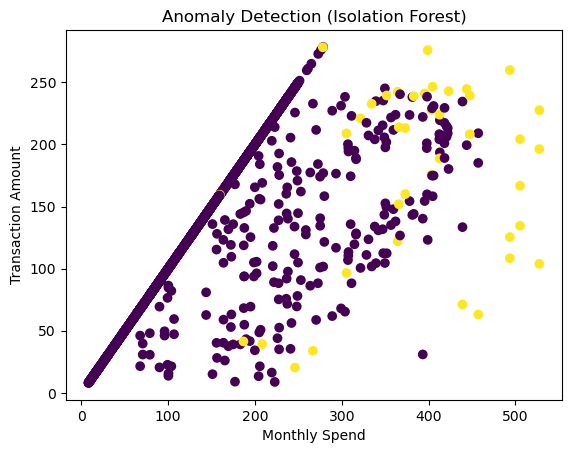

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(
    df_model["monthly_card_spend"],
    df_model["amount"],
    c=df_model["anomaly_flag"]
)
plt.xlabel("Monthly Spend")
plt.ylabel("Transaction Amount")
plt.title("Anomaly Detection (Isolation Forest)")
plt.show()

🔹 MODEL 5 — KMeans (Spending Behavior Segmentation)

1️⃣ Problem

“What type of spender is this user?”

2️⃣ Columns
	•	monthly_card_spend
	•	amount
	•	amt_vs_climit

3️⃣ What you get
	•	Segments users into:
	•	Low spenders
	•	Regular spenders
	•	High-risk spenders
	•	Great for personalized recommendations

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

cluster_features = df_model[
    ["monthly_card_spend", "amount", "amt_vs_climit"]
].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_features)

kmeans = KMeans(n_clusters=3, random_state=42)
df_model["spender_cluster"] = kmeans.fit_predict(X_scaled)

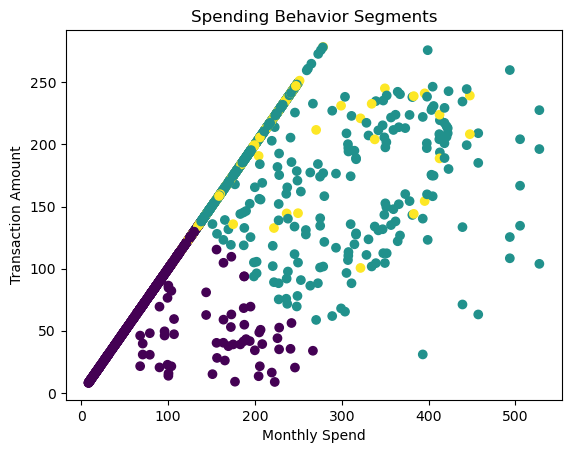

In [27]:
plt.figure()
plt.scatter(
    df_model["monthly_card_spend"],
    df_model["amount"],
    c=df_model["spender_cluster"]
)
plt.xlabel("Monthly Spend")
plt.ylabel("Transaction Amount")
plt.title("Spending Behavior Segments")
plt.show()

🔹 MODEL 6 — Hypothesis Testing (Statistical Validation)

1️⃣ Problem

“Is this month’s spending genuinely different or just random noise?”

2️⃣ Columns
	•	amount
	•	month_year

3️⃣ What you get
	•	Confirms real spikes
	•	Prevents false alarms
	•	Makes alerts statistically justified

In [11]:
from scipy.stats import ttest_ind

prev_month = df_model[df_model["month_year"] == "2024-11"]["amount"]
curr_month = df_model[df_model["month_year"] == "2024-12"]["amount"]

t_stat, p_value = ttest_ind(curr_month, prev_month, equal_var=False)

print("p-value:", p_value)

if p_value < 0.05:
    print("⚠️ Statistically significant increase detected")
else:
    print("✅ No significant change")

p-value: 0.891556497207091
✅ No significant change


C:\Users\trish\AppData\Local\Temp\ipykernel_23512\2410730601.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([prev_month, curr_month], labels=["Previous", "Current"])


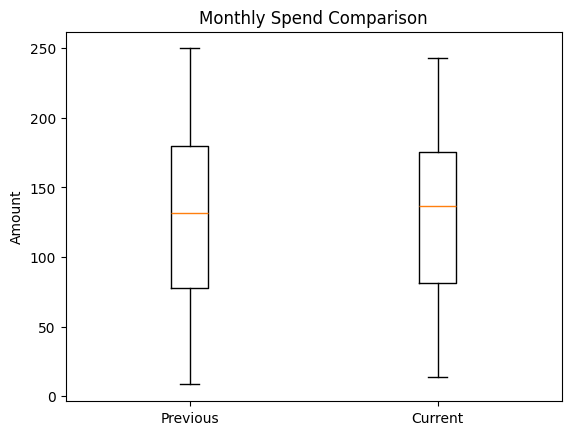

In [12]:
plt.figure()
plt.boxplot([prev_month, curr_month], labels=["Previous", "Current"])
plt.title("Monthly Spend Comparison")
plt.ylabel("Amount")
plt.show()

🔹 MODEL 7 — Rule + ML Hybrid (Final Decision Engine)

1️⃣ Problem

“Should I alert the user right now?”

2️⃣ Inputs
	•	XGBoost prediction
	•	Isolation Forest anomaly
	•	Rule violations (limit, merchant cap)

3️⃣ What you get
	•	Production-grade decision logic
	•	Low false positives
	•	High trust alerts

In [35]:
df_model["final_risk_flag"] = np.where(
    (df_model["card_credit_limit_exceeded"] == 1) |
    (df_model["anomaly_flag"] == 1) |
    (df_model["amt_vs_climit"] > 0.8),
    1,
    0
)

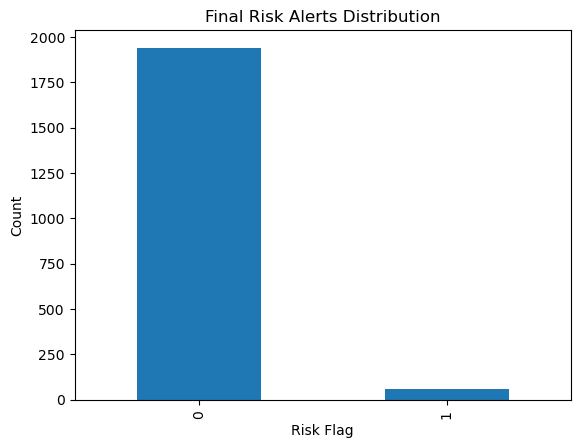

In [37]:
plt.figure()
df_model["final_risk_flag"].value_counts().plot(kind="bar")
plt.title("Final Risk Alerts Distribution")
plt.xlabel("Risk Flag")
plt.ylabel("Count")
plt.show()

🧩 Working model 1 — High-Risk Customer Outreach Model

(Who should customer care proactively call?)

📌 Problem (Customer Care POV)

“Which customers are likely to face a credit issue soon and should receive proactive support?”

This helps customer care:
	•	Call before frustration happens
	•	Prevent card blocks, failed payments, angry calls

⸻

🔍 What this model does
	•	Scores customers based on:
	•	high utilization
	•	frequent anomalies
	•	rising monthly spend
	•	Produces a priority outreach list

⸻

📊 Columns used
	•	person_name
	•	ssn
	•	card_id
	•	monthly_card_spend
	•	card_credit_limit
	•	amt_vs_climit
	•	anomaly_flag
	•	final_risk_flag

In [40]:
# Aggregate at customer-card level
cc_risk = (
    df_model.groupby(["person_name", "ssn", "card_id"])
    .agg(
        monthly_spend=("monthly_card_spend", "mean"),
        credit_limit=("card_credit_limit", "max"),
        avg_utilization=("amt_vs_climit", "mean"),
        anomaly_count=("anomaly_flag", "sum"),
        risk_events=("final_risk_flag", "sum")
    )
    .reset_index()
)

# Risk score for customer care
cc_risk["care_priority_score"] = (
    cc_risk["avg_utilization"] * 0.5 +
    (cc_risk["anomaly_count"] > 0).astype(int) * 0.3 +
    (cc_risk["risk_events"] > 0).astype(int) * 0.2
)

# Top customers to call
customer_care_outreach = (
    cc_risk.sort_values("care_priority_score", ascending=False)
           .head(10)
)

customer_care_outreach

,person_name,ssn,card_id,monthly_spend,credit_limit,avg_utilization,anomaly_count,risk_events,care_priority_score
556,Sneha Gupta,130-40-2110,CC013,200.743333,2406,0.083434,2,2,0.541717
380,Mia Jones,217-19-5329,CC013,183.540000,2322,0.079044,1,1,0.539522
206,Emma Wilson,161-77-3257,CC006,242.790000,3354,0.072388,1,1,0.536194
66,Andrew Smith,159-63-3183,CC010,224.036667,3139,0.071372,2,2,0.535686
370,Mia Garcia,140-20-2480,CC003,146.050000,2258,0.064681,1,1,0.532341
205,Emma Wilson,161-77-3257,CC003,153.605000,2421,0.063447,1,1,0.531723
65,Andrew Smith,159-63-3183,CC006,188.135000,3202,0.058755,1,1,0.529378
534,Sahil Malhotra,252-84-6624,CC009,120.925000,2153,0.056166,1,1,0.528083
110,Charlotte Davis,244-28-6328,CC009,177.485000,3241,0.054762,1,1,0.527381
168,Diya Patel,119-53-1703,CC007,117.200000,2205,0.053152,1,1,0.526576


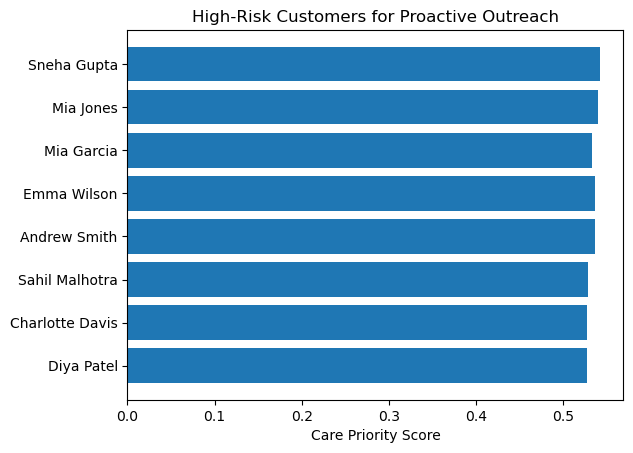

In [42]:
import matplotlib.pyplot as plt

top_cc = customer_care_outreach.sort_values(
    "care_priority_score", ascending=True
)

plt.figure()
plt.barh(
    top_cc["person_name"],
    top_cc["care_priority_score"]
)
plt.xlabel("Care Priority Score")
plt.title("High-Risk Customers for Proactive Outreach")
plt.show()

🧩 MODEL 2 — Subscription Complaint Prediction

(Why is the customer calling us?)

📌 Problem

“Which customers are likely to complain about subscriptions or recurring charges?”

This is huge for call centers.

⸻

🔍 What the model does
	•	Detects:
	•	sudden subscription amount jumps
	•	repeated monthly charges
	•	same merchant recurring
	•	Flags potential billing complaints

⸻

📊 Columns used
	•	person_name
	•	merchant
	•	category == "Subscription"
	•	amount
	•	month_year
	•	card_id

In [45]:
# Subscription-only data
subs = df_model[df_model["category"].str.lower().str.contains("subscription", na=False)]

subs_summary = (
    subs.groupby(["person_name", "card_id", "merchant"])
    .agg(
        avg_amount=("amount", "mean"),
        max_amount=("amount", "max"),
        txn_count=("amount", "count")
    )
    .reset_index()
)

# Flag suspicious subscription behavior
subs_summary["subscription_issue_flag"] = np.where(
    (subs_summary["max_amount"] > subs_summary["avg_amount"] * 1.5) |
    (subs_summary["txn_count"] > 12),
    1,
    0
)

subscription_complaints = subs_summary[
    subs_summary["subscription_issue_flag"] == 1
]

subscription_complaints

,person_name,card_id,merchant,avg_amount,max_amount,txn_count,subscription_issue_flag


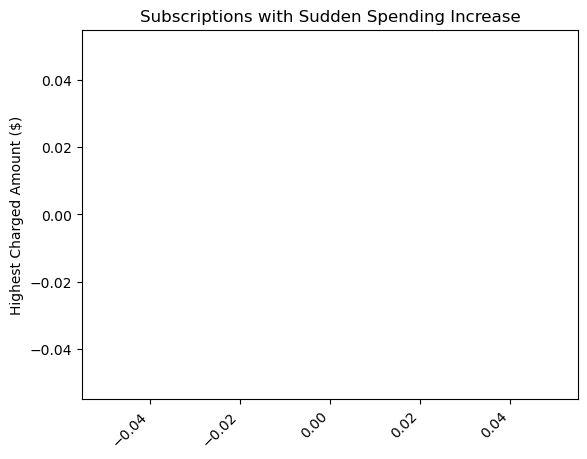

In [47]:
subs_flagged = subscription_complaints.sort_values(
    "max_amount", ascending=False
)

plt.figure()
plt.bar(
    subs_flagged["merchant"],
    subs_flagged["max_amount"]
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Highest Charged Amount ($)")
plt.title("Subscriptions with Sudden Spending Increase")
plt.show()

🧩 MODEL 3 — Customer Experience Friction Model

(Who is frustrated and why?)

📌 Problem

“Which customers are experiencing repeated payment problems across cards?”

This helps:
	•	Reduce repeat calls
	•	Improve retention
	•	Assign senior agents to high-friction users

⸻

🔍 What the model does
	•	Looks for:
	•	multiple cards affected
	•	anomalies + limit issues
	•	spending volatility
	•	Creates a friction score

⸻

📊 Columns used
	•	person_name
	•	ssn
	•	card_id
	•	monthly_card_spend
	•	card_credit_limit_exceeded
	•	anomaly_flag

In [50]:
friction = (
    df_model.groupby(["person_name", "ssn"])
    .agg(
        cards_used=("card_id", "nunique"),
        total_spend=("amount", "sum"),
        exceed_events=("card_credit_limit_exceeded", "sum"),
        anomaly_events=("anomaly_flag", "sum")
    )
    .reset_index()
)

# Friction score
friction["customer_friction_score"] = (
    friction["cards_used"] * 0.3 +
    friction["exceed_events"] * 0.4 +
    friction["anomaly_events"] * 0.3
)

high_friction_customers = friction.sort_values(
    "customer_friction_score", ascending=False
).head(10)

high_friction_customers

,person_name,ssn,cards_used,total_spend,exceed_events,anomaly_events,customer_friction_score
189,Riya Sharma,287-59-7919,1,2237.40,0,6,2.1
81,Emma Wilson,161-77-3257,4,1068.10,0,2,1.8
25,Andrew Smith,159-63-3183,3,1561.47,0,3,1.8
77,Emma Davis,345-15-1065,4,1978.28,0,1,1.5
248,William Jones,339-63-9843,4,1049.16,0,1,1.5
224,Sneha Gupta,130-40-2110,3,924.14,0,2,1.5
216,Sahil Malhotra,252-84-6624,4,2337.62,0,1,1.5
78,Emma Garcia,290-80-8030,1,714.36,0,4,1.5
174,Olivia Brown,201-87-4737,3,1558.81,0,2,1.5
45,Charlotte Garcia,329-83-9473,3,1746.06,0,2,1.5


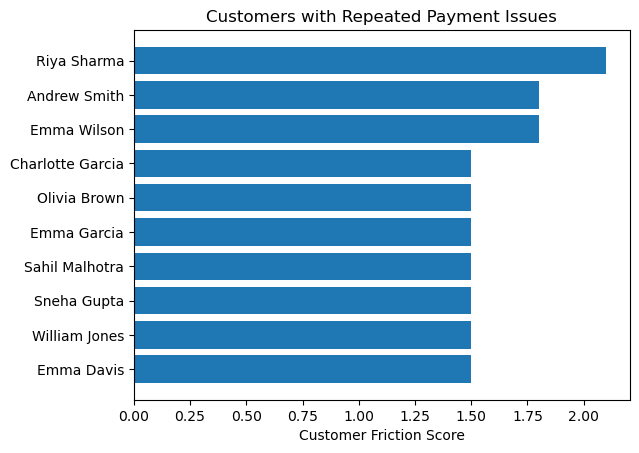

In [52]:
top_friction = high_friction_customers.sort_values(
    "customer_friction_score", ascending=True
)

plt.figure()
plt.barh(
    top_friction["person_name"],
    top_friction["customer_friction_score"]
)
plt.xlabel("Customer Friction Score")
plt.title("Customers with Repeated Payment Issues")
plt.show()